In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [2]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D

In [4]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
MIXED_PRECISION = True
SHUFFLE = True

# Mixed-precision setting
if MIXED_PRECISION:
    policy = keras.mixed_precision.Policy("mixed_float16")
    keras.mixed_precision.set_global_policy(policy)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [7]:
image_files_trainx = [os.path.join('/content/gdrive/MyDrive/DRIVE/training/images', f) for f in os.listdir('/content/gdrive/MyDrive/DRIVE/training/images')]
image_files_trainy = [os.path.join('/content/gdrive/MyDrive/DRIVE/training/1st_manual', f) for f in os.listdir('/content/gdrive/MyDrive/DRIVE/training/1st_manual')]


In [8]:
print(image_files_trainy)

['/content/gdrive/MyDrive/DRIVE/training/1st_manual/27_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/31_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/26_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/33_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/34_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/24_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/21_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/32_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/23_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/22_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/36_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/25_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/29_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_manual/37_manual1.gif', '/content/gdrive/MyDrive/DRIVE/training/1st_man

Shape of the TIFF stack: (40, 224, 224, 3)
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.02352941 0.02745098 0.01960784]
  [0.03529412 0.02745098 0.02352941]
  [0.03137255 0.02352941 0.02352941]
  ...
  [0.02745098 0.02745098 0.02745098]
  [0.03137255 0.03137255 0.03137255]
  [0.03529412 0.02352941 0.03137255]]

 [[0.02352941 0.01960784 0.0274

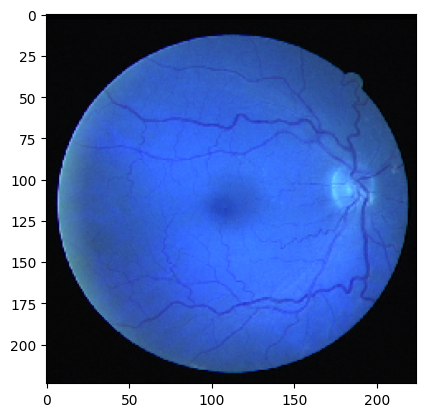

In [9]:

import skimage.io as io
from skimage import transform

resized_train_images = []
for image_path in image_files_trainx:
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST) / 255.0
    resized_train_images.append(resized_image)

train_images = np.array(resized_train_images)
train_images = np.repeat(train_images, 2, axis=0)

print("Shape of the TIFF stack:", train_images.shape)
plt.imshow(train_images[0])

print(train_images[0])

Shape of the TIFF stack: (40, 224, 224)
[0. 1.]


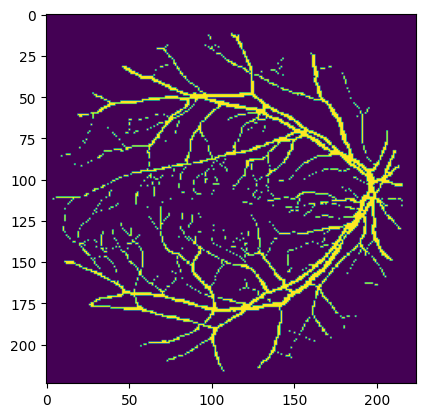

In [10]:
from PIL import Image

resized_train_masks = []
for image_path in image_files_trainy:
    #print(image_path)
    image = np.array(Image.open(image_path))
    #print(image)
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST) / 255.0
    resized_train_masks.append(resized_image)

train_masks = np.array(resized_train_masks)
train_masks = np.repeat(train_masks, 2, axis=0)


print("Shape of the TIFF stack:", train_masks.shape)

plt.imshow(train_masks[0])
print(np.unique(train_masks[0]))

In [11]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
print(n, h, w)
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

40 224 224


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [12]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

(40, 224, 224, 1)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(36, 224, 224, 3)
(4, 224, 224, 3)
(36, 224, 224, 1)
(4, 224, 224, 1)


In [14]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1]


In [15]:
print(y_train.shape)

(36, 224, 224, 1)


In [16]:
# Class weights to handle class imbalance
class_labels = np.unique(train_masks_reshaped_encoded)
class_counts = [np.sum(train_masks_reshaped_encoded == label) for label in class_labels]
total_samples = len(train_masks_reshaped_encoded)
class_weights = total_samples / (len(class_labels) * np.array(class_counts))

# Print the calculated class weights
print("Class Weights:", class_weights)

Class Weights: [0.5472639  5.78944939]


# Defining the model (Standard Conv Next:)



In [17]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

In [18]:
import tensorflow as tf

class SimpleFCN(tf.keras.Model):
    def __init__(self, num_channels_to_be_generated=16, name="simple_fcn_segmentation"):
        super(SimpleFCN, self).__init__(name=name)

        self.conv1 = tf.keras.layers.Conv2D(
            num_channels_to_be_generated,
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            name="conv1"
        )

        self.conv2 = tf.keras.layers.Conv2D(
            num_channels_to_be_generated,
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            name="conv2"
        )

        self.output_conv = tf.keras.layers.Conv2D(
            1,
            kernel_size=(1, 1),
            activation='sigmoid',
            name="output_conv"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.output_conv(x)
        return x

simple_fcn_model = SimpleFCN(num_channels_to_be_generated=64)


In [19]:
model = SimpleFCN()
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "simple_fcn_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              multiple                  448       
                                                                 
 conv2 (Conv2D)              multiple                  2320      
                                                                 
 output_conv (Conv2D)        multiple                  17        
                                                                 
Total params: 2785 (10.88 KB)
Trainable params: 2785 (10.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
X_train.shape

(36, 224, 224, 3)

In [21]:
model.call(np.array([X_train[0]]))

<tf.Tensor: shape=(1, 224, 224, 1), dtype=float16, numpy=
array([[[[0.5   ],
         [0.5   ],
         [0.5   ],
         ...,
         [0.5   ],
         [0.5   ],
         [0.5   ]],

        [[0.5005],
         [0.5   ],
         [0.5   ],
         ...,
         [0.5   ],
         [0.5   ],
         [0.5   ]],

        [[0.5   ],
         [0.4995],
         [0.4998],
         ...,
         [0.4998],
         [0.5005],
         [0.5005]],

        ...,

        [[0.5   ],
         [0.4983],
         [0.4978],
         ...,
         [0.4978],
         [0.4978],
         [0.5015]],

        [[0.4998],
         [0.4988],
         [0.498 ],
         ...,
         [0.4983],
         [0.4978],
         [0.5015]],

        [[0.5005],
         [0.5005],
         [0.4998],
         ...,
         [0.5   ],
         [0.4998],
         [0.5015]]]], dtype=float16)>

In [22]:
loss='mae'
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=[
        'accuracy',
    ],
)


In [23]:
print(class_weights)

[0.5472639  5.78944939]


In [24]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))


False
False


In [25]:

history = model.fit(X_train, y_train, epochs=1, batch_size=4, validation_data=(X_test, y_test))

9/9 [==============================] - 76s 8s/step - loss: nan - accuracy: 0.8816 - val_loss: nan - val_accuracy: 0.8742


In [26]:
print(X_test.shape, y_test.shape)

metrics = model.evaluate(X_test, y_test, batch_size=1)
print(metrics)
print("Accuracy is = ", (metrics[1] * 100.0), "%")

(4, 224, 224, 3) (4, 224, 224, 1)
4/4 [==============================] - 1s 117ms/step - loss: 0.4861 - accuracy: 0.8742
[0.486083984375, 0.874177873134613]
Accuracy is =  87.4177873134613 %


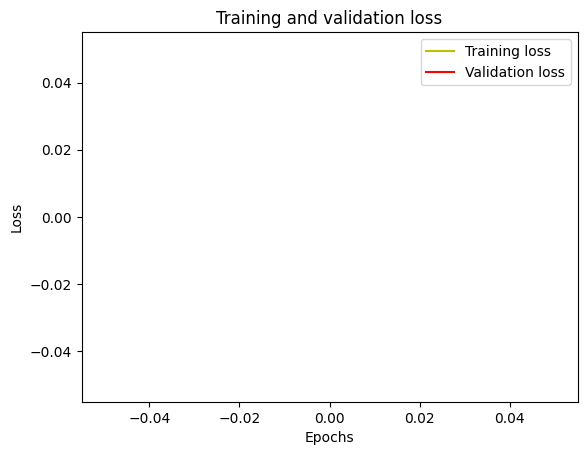

{'loss': [nan], 'accuracy': [0.8815818428993225], 'val_loss': [nan], 'val_accuracy': [0.874177873134613]}


In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(history.history)

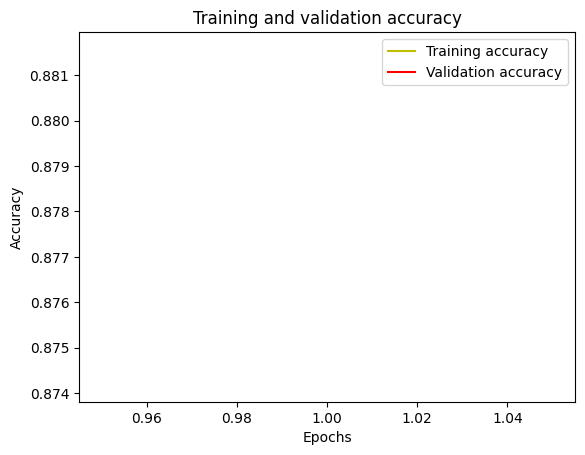

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The CNN failed. What about using LSTM's with CNN?

In [29]:
import tensorflow as tf

class FCNWithLSTM(tf.keras.Model):
    def __init__(self, num_channels_to_be_generated, name="fcn_with_lstm", **kwargs):
        super().__init__(name=name, **kwargs)

        self.input_projection = tf.keras.layers.Conv2D(filters=num_channels_to_be_generated,
                                                       kernel_size=(2, 2),
                                                       padding='same',
                                                       activation='relu',
                                                       name="convolution_layer")

        self.lstm_layer = tf.keras.layers.LSTM(units=num_channels_to_be_generated,
                                              return_sequences=True,
                                              activation='tanh',
                                              name="lstm_layer")

        self.output_projection = tf.keras.layers.Conv2DTranspose(filters=1,
                                                                 kernel_size=(2, 2),
                                                                 padding='same',
                                                                 activation='sigmoid',
                                                                 name="transpose_convolution_2d_layer")

    def call(self, images):
        x = self.input_projection(images)

        # Reshape to fit the LSTM layer
        _, h, w, c = x.shape
        x = tf.reshape(x, (-1, w, c))

        # Apply LSTM
        x = self.lstm_layer(x)

        # Reshape back to the original shape
        x = tf.reshape(x, (-1, h, w, c))

        x = self.output_projection(x)

        return x

# Create an instance of the model
model_with_lstm = FCNWithLSTM(num_channels_to_be_generated=32)
model_with_lstm.build(input_shape=(None, 224, 224, 3))
# Display the model summary
model_with_lstm.summary()


Model: "fcn_with_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_layer (Conv2D)  multiple                  416       
                                                                 
 lstm_layer (LSTM)           multiple                  8320      
                                                                 
 transpose_convolution_2d_l  multiple                  129       
 ayer (Conv2DTranspose)                                          
                                                                 
Total params: 8865 (34.63 KB)
Trainable params: 8865 (34.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
model = model_with_lstm

In [31]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        'accuracy',
    ],
)


In [32]:

history = model.fit(X_train, y_train, epochs=5, batch_size=1, validation_data=(X_test, y_test))

Epoch 1/5
36/36 [==============================] - 318s 9s/step - loss: 0.4636 - accuracy: 0.8644 - val_loss: 0.3402 - val_accuracy: 0.9072
Epoch 2/5
36/36 [==============================] - 314s 9s/step - loss: 0.3091 - accuracy: 0.9144 - val_loss: 0.3154 - val_accuracy: 0.9072
Epoch 3/5
36/36 [==============================] - 312s 9s/step - loss: 0.2898 - accuracy: 0.9144 - val_loss: 0.2911 - val_accuracy: 0.9072
Epoch 4/5
36/36 [==============================] - 313s 9s/step - loss: 0.2742 - accuracy: 0.9144 - val_loss: 0.2844 - val_accuracy: 0.9072
Epoch 5/5
36/36 [==============================] - 312s 9s/step - loss: 0.2683 - accuracy: 0.9144 - val_loss: 0.2806 - val_accuracy: 0.9072


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


KeyboardInterrupt: 

In [33]:
y_train_cat = y_train
y_test_cat = y_test

In [34]:
from scipy.ndimage import rotate
def apply_random_rotation(image, mask):
    angle = np.random.uniform(0, 180)
    rotated_image = rotate(image, angle, reshape=False, mode='reflect')
    rotated_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        rotated_channel = rotate(mask[..., channel], angle, reshape=False, mode='reflect')
        rotated_mask[..., channel] = (rotated_channel > 0.5).astype(np.float32)
    return rotated_image, rotated_mask

In [35]:
def apply_horizontal_flip(image, mask):
    flipped_image = np.fliplr(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.fliplr(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [36]:
def apply_vertical_flip(image, mask):
    flipped_image = np.flipud(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.flipud(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [37]:
augmented_image, augmented_mask = apply_vertical_flip(X_train[0], y_train_cat[0])
print("Image Shape: ", augmented_image.shape)
print("Mask Shape: ", augmented_mask.shape)

Image Shape:  (224, 224, 3)
Mask Shape:  (224, 224, 1)


In [38]:
augmented_images = []
augmented_masks = []
for i in range(X_train.shape[0]):
    rot_img, rot_mask = apply_random_rotation(X_train[i], y_train_cat[i])
    h_flip_img, h_flip_mask = apply_horizontal_flip(X_train[i], y_train_cat[i])
    v_flip_img, v_flip_mask = apply_vertical_flip(X_train[i], y_train_cat[i])

    augmented_images.append(rot_img)
    augmented_images.append(h_flip_img)
    augmented_images.append(v_flip_img)

    augmented_masks.append(rot_mask)
    augmented_masks.append(h_flip_mask)
    augmented_masks.append(v_flip_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
print("Aug Image Shape: ", augmented_images.shape)
print("Aug Mask Shape: ", augmented_masks.shape)

Aug Image Shape:  (108, 224, 224, 3)
Aug Mask Shape:  (108, 224, 224, 1)


In [39]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train_cat, augmented_masks), axis = 0)

#y_train_aug = np.argmax(y_train_aug, axis=-1)
#y_train_aug = y_train_aug[..., np.newaxis]

print("Full Aug Image Shape: ", X_train_aug.shape)
print("Full Aug Mask Shape: ", y_train_aug.shape)

print(y_test.shape, X_test.shape)

Full Aug Image Shape:  (144, 224, 224, 3)
Full Aug Mask Shape:  (144, 224, 224, 1)
(4, 224, 224, 1) (4, 224, 224, 3)


In [41]:
# Increasing the number of epochs from 50 ==> 100
# Using the augmented dataset of images and masks
history_aug = model.fit(X_train_aug[:100], y_train_aug[:100],
                    verbose=1,
                        batch_size=1,
                    epochs=1,
                    validation_data=(X_test, y_test),
                    shuffle=False)

100/100 [==============================] - 843s 8s/step - loss: 0.2653 - accuracy: 0.9131 - val_loss: 0.2745 - val_accuracy: 0.9072


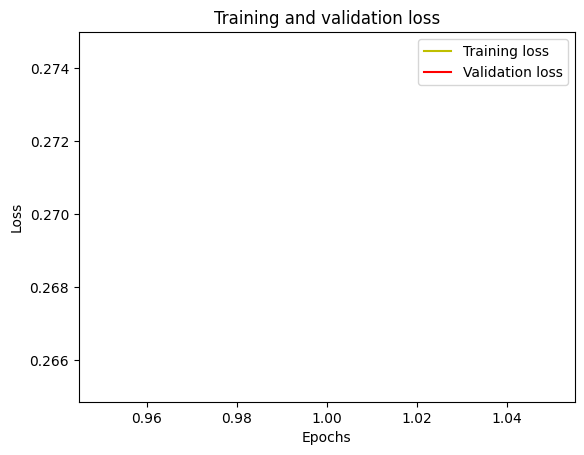

In [43]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

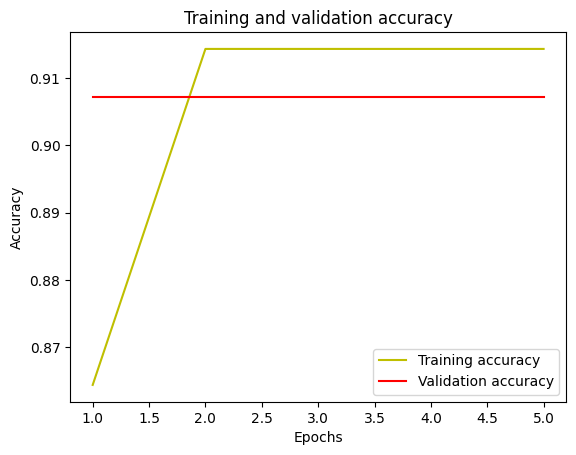

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Comparitive analysis of evaluation metrics of the models on the sandstone dataset

(36, 224, 224, 3)
36/36 [==============================] - 107s 3s/step
(36, 224, 224, 1)


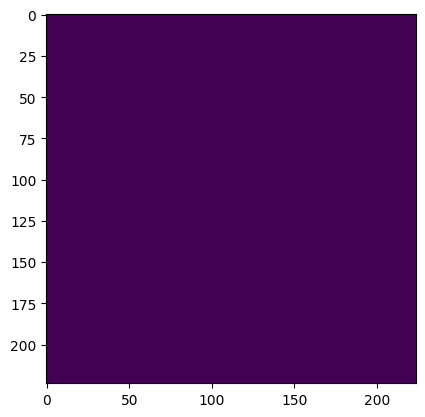

In [45]:
# prediction on training set
print(X_train.shape)

y_pred=model.predict(X_train, batch_size=1)
print(y_pred.shape)
y_pred_argmax=np.argmax(y_pred, axis=-1)

plt.imshow(y_pred_argmax[0])

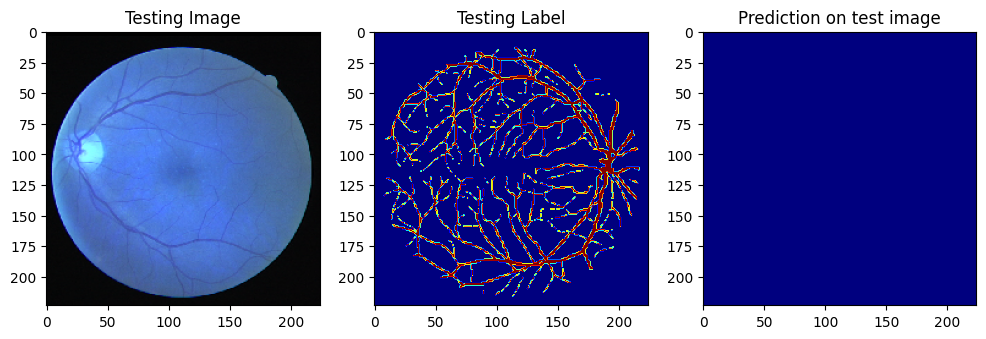

In [46]:
test_img = X_test[1]
ground_truth = y_test[1]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred_argmax[0], cmap='jet')
plt.show()

In [47]:
print("true: ", y_test_cat.shape)
print("pred: ", y_pred.shape)

true:  (4, 224, 224, 1)
pred:  (36, 224, 224, 1)


In [48]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

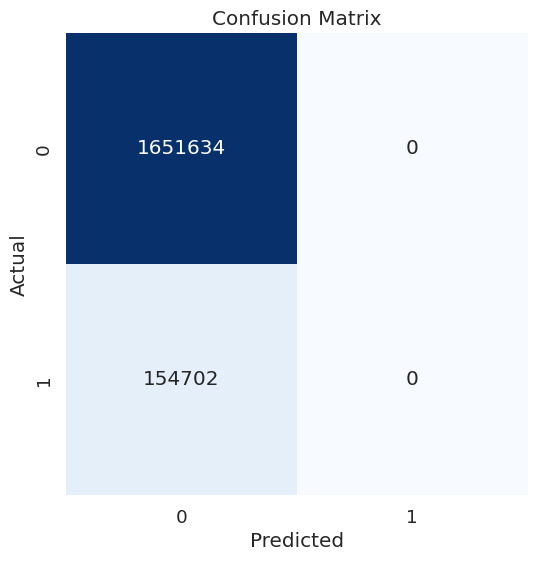

In [49]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_train.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [50]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_test, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 0.0%


<ipython-input-50-dd5d94b86577>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  matching_pixels = np.sum(gnd_flat == pred_flat)


In [51]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_test, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_test, y_pred_img, 2)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")


Class 0 precision: 91%
Class 1 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# recall
def classwise_recall(y_test, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_test, y_pred_img, 2)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")


Class 0 precision: 100%
Class 1 precision: 0%


In [53]:
# f1-score
def classwise_f1_score(y_test, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_test, y_pred_img, 2)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")

Class 0 precision: 100%
Class 1 precision: 0%


In [54]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_train, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.45717797


In [55]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)

[[1651634.       0.]
 [ 154702.       0.]]
IoU for class1 is:  0.91435593
IoU for class2 is:  0.0


Training Set

In [56]:
# prediction on training set
y_pred=model.predict(X_test, batch_size=1)
y_pred_argmax=np.argmax(y_pred, axis=3)

4/4 [==============================] - 11s 3s/step


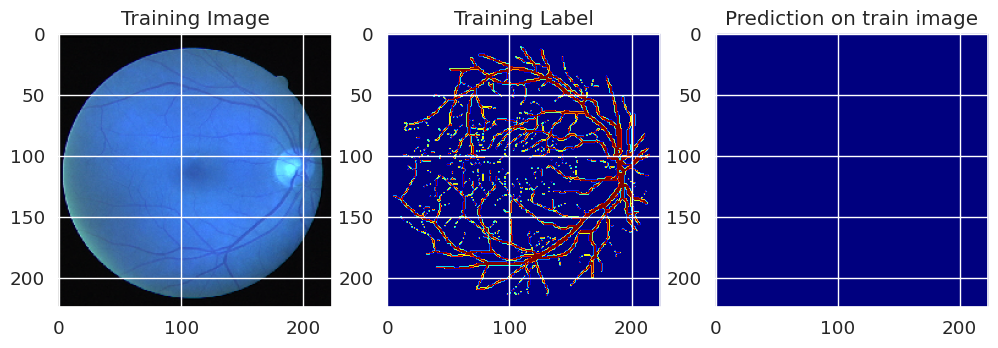

In [57]:
import random
train_img_number = random.randint(0, 2)



plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(X_test[train_img_number], cmap='gray')
plt.subplot(232)
plt.title('Training Label')
plt.imshow(y_train[train_img_number], cmap='jet')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(y_pred_argmax[train_img_number], cmap='jet')
plt.show()

In [58]:
print("true: ", y_train_cat.shape)
print("pred: ", y_pred.shape)

true:  (36, 224, 224, 1)
pred:  (4, 224, 224, 1)


In [59]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

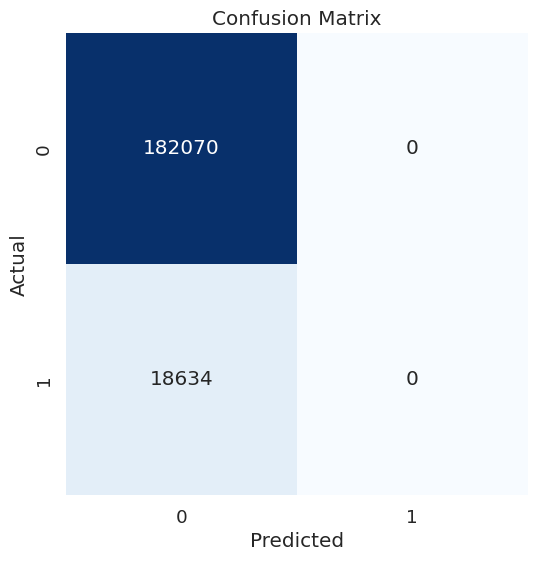

In [60]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_train, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 0.0%


<ipython-input-61-3689c83f910d>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  matching_pixels = np.sum(gnd_flat == pred_flat)


In [62]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_train, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 91%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
# recall
def classwise_recall(y_train, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 100%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# f1-score
def classwise_f1_score(y_train, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 100%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.4535784


In [66]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] +  values[0,1])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)

[[182070.      0.]
 [ 18634.      0.]]
IoU for class1 is:  0.9071568
IoU for class2 is:  0.0
